In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [5]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [6]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [22]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 10

In [23]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [24]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

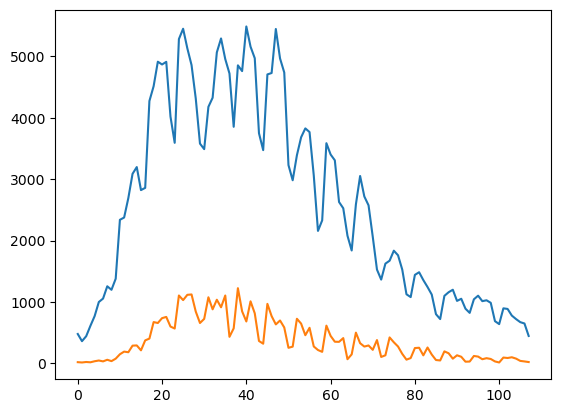

In [25]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [26]:
GPi = np.load('EuropeCovid2_GPi.npz')

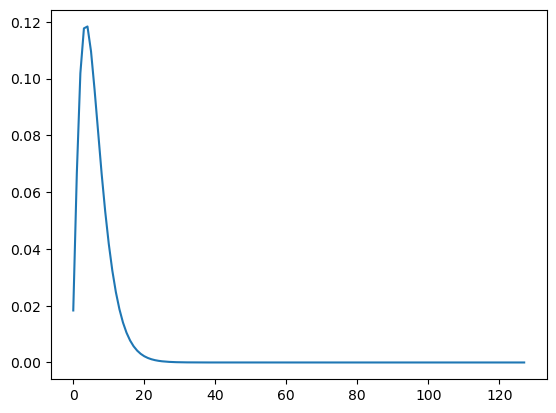

In [27]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

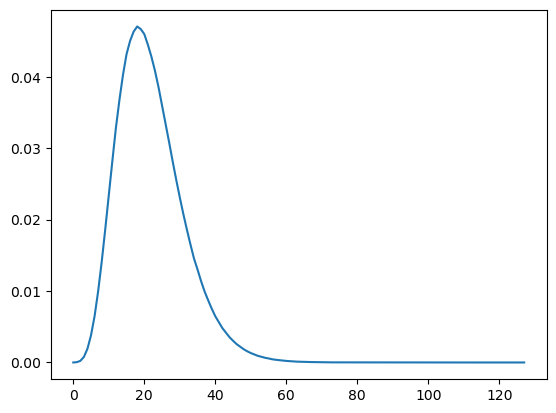

In [28]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [29]:
# A
d = 2
A = np.zeros([T+T0, d])

In [30]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

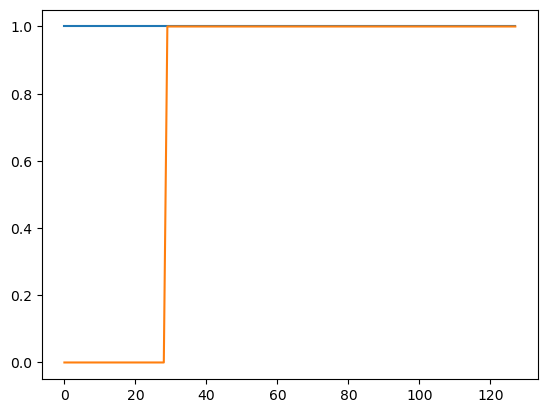

In [31]:
plt.plot(A)

# 3. fit by EM algorithm

In [32]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [33]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [34]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [46]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/1000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = rhat + ss * dth[0]
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [47]:
rmle = 5.2
mmle_0 = 25.3
bmle = [0.36, -2.45]

In [48]:
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=1)

Before EM, ll: -679.658323
1-th iteration finished, ll: -660.973425, lapse: 0.018sec.
2-th iteration finished, ll: -647.346523, lapse: 0.010sec.
3-th iteration finished, ll: -647.045078, lapse: 0.013sec.
4-th iteration finished, ll: -647.043152, lapse: 0.005sec.
5-th iteration finished, ll: -647.041622, lapse: 0.008sec.
6-th iteration finished, ll: -647.040192, lapse: 0.008sec.
7-th iteration finished, ll: -647.038855, lapse: 0.004sec.
8-th iteration finished, ll: -647.037600, lapse: 0.004sec.
9-th iteration finished, ll: -647.036422, lapse: 0.009sec.
10-th iteration finished, ll: -647.035312, lapse: 0.006sec.
11-th iteration finished, ll: -647.034265, lapse: 0.004sec.
12-th iteration finished, ll: -647.033276, lapse: 0.011sec.
13-th iteration finished, ll: -647.032338, lapse: 0.004sec.
14-th iteration finished, ll: -647.031448, lapse: 0.004sec.
15-th iteration finished, ll: -647.030600, lapse: 0.005sec.
16-th iteration finished, ll: -647.029792, lapse: 0.008sec.
17-th iteration finish

165-th iteration finished, ll: -646.966505, lapse: 0.011sec.
166-th iteration finished, ll: -646.966143, lapse: 0.057sec.
167-th iteration finished, ll: -646.965781, lapse: 0.014sec.
168-th iteration finished, ll: -646.965420, lapse: 0.026sec.
169-th iteration finished, ll: -646.965060, lapse: 0.005sec.
170-th iteration finished, ll: -646.964700, lapse: 0.004sec.
171-th iteration finished, ll: -646.964340, lapse: 0.012sec.
172-th iteration finished, ll: -646.963981, lapse: 0.004sec.
173-th iteration finished, ll: -646.963622, lapse: 0.014sec.
174-th iteration finished, ll: -646.963264, lapse: 0.010sec.
175-th iteration finished, ll: -646.962906, lapse: 0.004sec.
176-th iteration finished, ll: -646.962549, lapse: 0.006sec.
177-th iteration finished, ll: -646.962193, lapse: 0.007sec.
178-th iteration finished, ll: -646.961836, lapse: 0.006sec.
179-th iteration finished, ll: -646.961481, lapse: 0.008sec.
180-th iteration finished, ll: -646.961125, lapse: 0.005sec.
181-th iteration finishe

322-th iteration finished, ll: -646.915173, lapse: 0.005sec.
323-th iteration finished, ll: -646.914878, lapse: 0.016sec.
324-th iteration finished, ll: -646.914584, lapse: 0.005sec.
325-th iteration finished, ll: -646.914291, lapse: 0.004sec.
326-th iteration finished, ll: -646.913997, lapse: 0.007sec.
327-th iteration finished, ll: -646.913704, lapse: 0.017sec.
328-th iteration finished, ll: -646.913412, lapse: 0.006sec.
329-th iteration finished, ll: -646.913120, lapse: 0.006sec.
330-th iteration finished, ll: -646.912828, lapse: 0.009sec.
331-th iteration finished, ll: -646.912537, lapse: 0.009sec.
332-th iteration finished, ll: -646.912245, lapse: 0.005sec.
333-th iteration finished, ll: -646.911955, lapse: 0.004sec.
334-th iteration finished, ll: -646.911665, lapse: 0.006sec.
335-th iteration finished, ll: -646.911375, lapse: 0.008sec.
336-th iteration finished, ll: -646.911085, lapse: 0.004sec.
337-th iteration finished, ll: -646.910796, lapse: 0.004sec.
338-th iteration finishe

490-th iteration finished, ll: -646.870566, lapse: 0.006sec.
491-th iteration finished, ll: -646.870327, lapse: 0.009sec.
492-th iteration finished, ll: -646.870088, lapse: 0.023sec.
493-th iteration finished, ll: -646.869850, lapse: 0.010sec.
494-th iteration finished, ll: -646.869612, lapse: 0.011sec.
495-th iteration finished, ll: -646.869375, lapse: 0.010sec.
496-th iteration finished, ll: -646.869138, lapse: 0.008sec.
497-th iteration finished, ll: -646.868901, lapse: 0.006sec.
498-th iteration finished, ll: -646.868664, lapse: 0.004sec.
499-th iteration finished, ll: -646.868427, lapse: 0.011sec.
500-th iteration finished, ll: -646.868191, lapse: 0.013sec.
501-th iteration finished, ll: -646.867955, lapse: 0.005sec.
502-th iteration finished, ll: -646.867720, lapse: 0.012sec.
503-th iteration finished, ll: -646.867485, lapse: 0.004sec.
504-th iteration finished, ll: -646.867250, lapse: 0.014sec.
505-th iteration finished, ll: -646.867015, lapse: 0.011sec.
506-th iteration finishe

643-th iteration finished, ll: -646.837171, lapse: 0.009sec.
644-th iteration finished, ll: -646.836972, lapse: 0.011sec.
645-th iteration finished, ll: -646.836773, lapse: 0.011sec.
646-th iteration finished, ll: -646.836575, lapse: 0.013sec.
647-th iteration finished, ll: -646.836376, lapse: 0.012sec.
648-th iteration finished, ll: -646.836178, lapse: 0.006sec.
649-th iteration finished, ll: -646.835980, lapse: 0.005sec.
650-th iteration finished, ll: -646.835783, lapse: 0.005sec.
651-th iteration finished, ll: -646.835585, lapse: 0.004sec.
652-th iteration finished, ll: -646.835388, lapse: 0.012sec.
653-th iteration finished, ll: -646.835191, lapse: 0.010sec.
654-th iteration finished, ll: -646.834994, lapse: 0.010sec.
655-th iteration finished, ll: -646.834798, lapse: 0.012sec.
656-th iteration finished, ll: -646.834602, lapse: 0.006sec.
657-th iteration finished, ll: -646.834406, lapse: 0.006sec.
658-th iteration finished, ll: -646.834210, lapse: 0.005sec.
659-th iteration finishe

792-th iteration finished, ll: -646.809901, lapse: 0.010sec.
793-th iteration finished, ll: -646.809733, lapse: 0.019sec.
794-th iteration finished, ll: -646.809565, lapse: 0.014sec.
795-th iteration finished, ll: -646.809397, lapse: 0.010sec.
796-th iteration finished, ll: -646.809230, lapse: 0.007sec.
797-th iteration finished, ll: -646.809063, lapse: 0.010sec.
798-th iteration finished, ll: -646.808896, lapse: 0.008sec.
799-th iteration finished, ll: -646.808729, lapse: 0.028sec.
800-th iteration finished, ll: -646.808563, lapse: 0.007sec.
801-th iteration finished, ll: -646.808396, lapse: 0.009sec.
802-th iteration finished, ll: -646.808230, lapse: 0.007sec.
803-th iteration finished, ll: -646.808064, lapse: 0.010sec.
804-th iteration finished, ll: -646.807898, lapse: 0.007sec.
805-th iteration finished, ll: -646.807733, lapse: 0.004sec.
806-th iteration finished, ll: -646.807567, lapse: 0.004sec.
807-th iteration finished, ll: -646.807402, lapse: 0.004sec.
808-th iteration finishe

944-th iteration finished, ll: -646.786400, lapse: 0.010sec.
945-th iteration finished, ll: -646.786258, lapse: 0.017sec.
946-th iteration finished, ll: -646.786116, lapse: 0.007sec.
947-th iteration finished, ll: -646.785974, lapse: 0.004sec.
948-th iteration finished, ll: -646.785833, lapse: 0.004sec.
949-th iteration finished, ll: -646.785691, lapse: 0.011sec.
950-th iteration finished, ll: -646.785550, lapse: 0.009sec.
951-th iteration finished, ll: -646.785409, lapse: 0.007sec.
952-th iteration finished, ll: -646.785268, lapse: 0.006sec.
953-th iteration finished, ll: -646.785127, lapse: 0.009sec.
954-th iteration finished, ll: -646.784986, lapse: 0.009sec.
955-th iteration finished, ll: -646.784846, lapse: 0.004sec.
956-th iteration finished, ll: -646.784706, lapse: 0.004sec.
957-th iteration finished, ll: -646.784565, lapse: 0.008sec.
958-th iteration finished, ll: -646.784425, lapse: 0.006sec.
959-th iteration finished, ll: -646.784285, lapse: 0.004sec.
960-th iteration finishe

1109-th iteration finished, ll: -646.764903, lapse: 0.009sec.
1110-th iteration finished, ll: -646.764784, lapse: 0.014sec.
1111-th iteration finished, ll: -646.764665, lapse: 0.006sec.
1112-th iteration finished, ll: -646.764546, lapse: 0.005sec.
1113-th iteration finished, ll: -646.764427, lapse: 0.007sec.
1114-th iteration finished, ll: -646.764309, lapse: 0.009sec.
1115-th iteration finished, ll: -646.764190, lapse: 0.009sec.
1116-th iteration finished, ll: -646.764072, lapse: 0.004sec.
1117-th iteration finished, ll: -646.763953, lapse: 0.004sec.
1118-th iteration finished, ll: -646.763835, lapse: 0.005sec.
1119-th iteration finished, ll: -646.763717, lapse: 0.004sec.
1120-th iteration finished, ll: -646.763599, lapse: 0.004sec.
1121-th iteration finished, ll: -646.763481, lapse: 0.004sec.
1122-th iteration finished, ll: -646.763363, lapse: 0.005sec.
1123-th iteration finished, ll: -646.763246, lapse: 0.008sec.
1124-th iteration finished, ll: -646.763128, lapse: 0.004sec.
1125-th 

1242-th iteration finished, ll: -646.750086, lapse: 0.013sec.
1243-th iteration finished, ll: -646.749982, lapse: 0.011sec.
1244-th iteration finished, ll: -646.749878, lapse: 0.004sec.
1245-th iteration finished, ll: -646.749774, lapse: 0.004sec.
1246-th iteration finished, ll: -646.749671, lapse: 0.005sec.
1247-th iteration finished, ll: -646.749567, lapse: 0.004sec.
1248-th iteration finished, ll: -646.749464, lapse: 0.004sec.
1249-th iteration finished, ll: -646.749361, lapse: 0.004sec.
1250-th iteration finished, ll: -646.749257, lapse: 0.004sec.
1251-th iteration finished, ll: -646.749154, lapse: 0.008sec.
1252-th iteration finished, ll: -646.749051, lapse: 0.009sec.
1253-th iteration finished, ll: -646.748948, lapse: 0.006sec.
1254-th iteration finished, ll: -646.748846, lapse: 0.004sec.
1255-th iteration finished, ll: -646.748743, lapse: 0.004sec.
1256-th iteration finished, ll: -646.748640, lapse: 0.009sec.
1257-th iteration finished, ll: -646.748538, lapse: 0.004sec.
1258-th 

1396-th iteration finished, ll: -646.735254, lapse: 0.007sec.
1397-th iteration finished, ll: -646.735165, lapse: 0.015sec.
1398-th iteration finished, ll: -646.735076, lapse: 0.004sec.
1399-th iteration finished, ll: -646.734988, lapse: 0.009sec.
1400-th iteration finished, ll: -646.734899, lapse: 0.007sec.
1401-th iteration finished, ll: -646.734810, lapse: 0.005sec.
1402-th iteration finished, ll: -646.734721, lapse: 0.004sec.
1403-th iteration finished, ll: -646.734633, lapse: 0.007sec.
1404-th iteration finished, ll: -646.734545, lapse: 0.008sec.
1405-th iteration finished, ll: -646.734456, lapse: 0.004sec.
1406-th iteration finished, ll: -646.734368, lapse: 0.005sec.
1407-th iteration finished, ll: -646.734280, lapse: 0.009sec.
1408-th iteration finished, ll: -646.734192, lapse: 0.009sec.
1409-th iteration finished, ll: -646.734104, lapse: 0.006sec.
1410-th iteration finished, ll: -646.734016, lapse: 0.005sec.
1411-th iteration finished, ll: -646.733928, lapse: 0.006sec.
1412-th 

1560-th iteration finished, ll: -646.721758, lapse: 0.014sec.
1561-th iteration finished, ll: -646.721682, lapse: 0.007sec.
1562-th iteration finished, ll: -646.721607, lapse: 0.004sec.
1563-th iteration finished, ll: -646.721531, lapse: 0.009sec.
1564-th iteration finished, ll: -646.721455, lapse: 0.005sec.
1565-th iteration finished, ll: -646.721380, lapse: 0.004sec.
1566-th iteration finished, ll: -646.721304, lapse: 0.006sec.
1567-th iteration finished, ll: -646.721229, lapse: 0.008sec.
1568-th iteration finished, ll: -646.721153, lapse: 0.004sec.
1569-th iteration finished, ll: -646.721078, lapse: 0.004sec.
1570-th iteration finished, ll: -646.721003, lapse: 0.008sec.
1571-th iteration finished, ll: -646.720928, lapse: 0.005sec.
1572-th iteration finished, ll: -646.720853, lapse: 0.005sec.
1573-th iteration finished, ll: -646.720778, lapse: 0.006sec.
1574-th iteration finished, ll: -646.720703, lapse: 0.008sec.
1575-th iteration finished, ll: -646.720628, lapse: 0.004sec.
1576-th 

1717-th iteration finished, ll: -646.710692, lapse: 0.008sec.
1718-th iteration finished, ll: -646.710627, lapse: 0.019sec.
1719-th iteration finished, ll: -646.710561, lapse: 0.012sec.
1720-th iteration finished, ll: -646.710496, lapse: 0.006sec.
1721-th iteration finished, ll: -646.710431, lapse: 0.005sec.
1722-th iteration finished, ll: -646.710366, lapse: 0.009sec.
1723-th iteration finished, ll: -646.710301, lapse: 0.006sec.
1724-th iteration finished, ll: -646.710236, lapse: 0.004sec.
1725-th iteration finished, ll: -646.710171, lapse: 0.005sec.
1726-th iteration finished, ll: -646.710106, lapse: 0.008sec.
1727-th iteration finished, ll: -646.710041, lapse: 0.004sec.
1728-th iteration finished, ll: -646.709976, lapse: 0.004sec.
1729-th iteration finished, ll: -646.709912, lapse: 0.008sec.
1730-th iteration finished, ll: -646.709847, lapse: 0.005sec.
1731-th iteration finished, ll: -646.709783, lapse: 0.004sec.
1732-th iteration finished, ll: -646.709718, lapse: 0.006sec.
1733-th 

1851-th iteration finished, ll: -646.702459, lapse: 0.009sec.
1852-th iteration finished, ll: -646.702401, lapse: 0.012sec.
1853-th iteration finished, ll: -646.702343, lapse: 0.006sec.
1854-th iteration finished, ll: -646.702286, lapse: 0.006sec.
1855-th iteration finished, ll: -646.702228, lapse: 0.008sec.
1856-th iteration finished, ll: -646.702171, lapse: 0.004sec.
1857-th iteration finished, ll: -646.702113, lapse: 0.006sec.
1858-th iteration finished, ll: -646.702056, lapse: 0.007sec.
1859-th iteration finished, ll: -646.701999, lapse: 0.010sec.
1860-th iteration finished, ll: -646.701941, lapse: 0.006sec.
1861-th iteration finished, ll: -646.701884, lapse: 0.010sec.
1862-th iteration finished, ll: -646.701827, lapse: 0.006sec.
1863-th iteration finished, ll: -646.701770, lapse: 0.004sec.
1864-th iteration finished, ll: -646.701713, lapse: 0.005sec.
1865-th iteration finished, ll: -646.701656, lapse: 0.005sec.
1866-th iteration finished, ll: -646.701599, lapse: 0.008sec.
1867-th 

2003-th iteration finished, ll: -646.694272, lapse: 0.008sec.
2004-th iteration finished, ll: -646.694222, lapse: 0.019sec.
2005-th iteration finished, ll: -646.694172, lapse: 0.006sec.
2006-th iteration finished, ll: -646.694122, lapse: 0.004sec.
2007-th iteration finished, ll: -646.694072, lapse: 0.009sec.
2008-th iteration finished, ll: -646.694022, lapse: 0.006sec.
2009-th iteration finished, ll: -646.693972, lapse: 0.004sec.
2010-th iteration finished, ll: -646.693922, lapse: 0.004sec.
2011-th iteration finished, ll: -646.693872, lapse: 0.008sec.
2012-th iteration finished, ll: -646.693822, lapse: 0.010sec.
2013-th iteration finished, ll: -646.693772, lapse: 0.009sec.
2014-th iteration finished, ll: -646.693723, lapse: 0.005sec.
2015-th iteration finished, ll: -646.693673, lapse: 0.004sec.
2016-th iteration finished, ll: -646.693623, lapse: 0.004sec.
2017-th iteration finished, ll: -646.693574, lapse: 0.010sec.
2018-th iteration finished, ll: -646.693524, lapse: 0.005sec.
2019-th 

2140-th iteration finished, ll: -646.687800, lapse: 0.009sec.
2141-th iteration finished, ll: -646.687756, lapse: 0.009sec.
2142-th iteration finished, ll: -646.687711, lapse: 0.006sec.
2143-th iteration finished, ll: -646.687667, lapse: 0.004sec.
2144-th iteration finished, ll: -646.687623, lapse: 0.007sec.
2145-th iteration finished, ll: -646.687578, lapse: 0.009sec.
2146-th iteration finished, ll: -646.687534, lapse: 0.007sec.
2147-th iteration finished, ll: -646.687490, lapse: 0.004sec.
2148-th iteration finished, ll: -646.687446, lapse: 0.004sec.
2149-th iteration finished, ll: -646.687402, lapse: 0.008sec.
2150-th iteration finished, ll: -646.687358, lapse: 0.005sec.
2151-th iteration finished, ll: -646.687314, lapse: 0.005sec.
2152-th iteration finished, ll: -646.687270, lapse: 0.006sec.
2153-th iteration finished, ll: -646.687226, lapse: 0.007sec.
2154-th iteration finished, ll: -646.687182, lapse: 0.004sec.
2155-th iteration finished, ll: -646.687138, lapse: 0.004sec.
2156-th 

2285-th iteration finished, ll: -646.681757, lapse: 0.009sec.
2286-th iteration finished, ll: -646.681718, lapse: 0.018sec.
2287-th iteration finished, ll: -646.681679, lapse: 0.008sec.
2288-th iteration finished, ll: -646.681640, lapse: 0.005sec.
2289-th iteration finished, ll: -646.681601, lapse: 0.008sec.
2290-th iteration finished, ll: -646.681562, lapse: 0.007sec.
2291-th iteration finished, ll: -646.681523, lapse: 0.005sec.
2292-th iteration finished, ll: -646.681484, lapse: 0.005sec.
2293-th iteration finished, ll: -646.681445, lapse: 0.007sec.
2294-th iteration finished, ll: -646.681407, lapse: 0.005sec.
2295-th iteration finished, ll: -646.681368, lapse: 0.007sec.
2296-th iteration finished, ll: -646.681329, lapse: 0.007sec.
2297-th iteration finished, ll: -646.681290, lapse: 0.004sec.
2298-th iteration finished, ll: -646.681252, lapse: 0.004sec.
2299-th iteration finished, ll: -646.681213, lapse: 0.008sec.
2300-th iteration finished, ll: -646.681175, lapse: 0.005sec.
2301-th 

2425-th iteration finished, ll: -646.676607, lapse: 0.006sec.
2426-th iteration finished, ll: -646.676572, lapse: 0.009sec.
2427-th iteration finished, ll: -646.676538, lapse: 0.017sec.
2428-th iteration finished, ll: -646.676503, lapse: 0.006sec.
2429-th iteration finished, ll: -646.676469, lapse: 0.004sec.
2430-th iteration finished, ll: -646.676434, lapse: 0.007sec.
2431-th iteration finished, ll: -646.676400, lapse: 0.008sec.
2432-th iteration finished, ll: -646.676365, lapse: 0.004sec.
2433-th iteration finished, ll: -646.676331, lapse: 0.004sec.
2434-th iteration finished, ll: -646.676297, lapse: 0.007sec.
2435-th iteration finished, ll: -646.676262, lapse: 0.004sec.
2436-th iteration finished, ll: -646.676228, lapse: 0.007sec.
2437-th iteration finished, ll: -646.676194, lapse: 0.009sec.
2438-th iteration finished, ll: -646.676159, lapse: 0.007sec.
2439-th iteration finished, ll: -646.676125, lapse: 0.004sec.
2440-th iteration finished, ll: -646.676091, lapse: 0.004sec.
2441-th 

2560-th iteration finished, ll: -646.672196, lapse: 0.009sec.
2561-th iteration finished, ll: -646.672165, lapse: 0.019sec.
2562-th iteration finished, ll: -646.672134, lapse: 0.008sec.
2563-th iteration finished, ll: -646.672104, lapse: 0.005sec.
2564-th iteration finished, ll: -646.672073, lapse: 0.005sec.
2565-th iteration finished, ll: -646.672042, lapse: 0.004sec.
2566-th iteration finished, ll: -646.672012, lapse: 0.009sec.
2567-th iteration finished, ll: -646.671981, lapse: 0.005sec.
2568-th iteration finished, ll: -646.671950, lapse: 0.004sec.
2569-th iteration finished, ll: -646.671920, lapse: 0.005sec.
2570-th iteration finished, ll: -646.671889, lapse: 0.008sec.
2571-th iteration finished, ll: -646.671859, lapse: 0.005sec.
2572-th iteration finished, ll: -646.671828, lapse: 0.004sec.
2573-th iteration finished, ll: -646.671798, lapse: 0.004sec.
2574-th iteration finished, ll: -646.671767, lapse: 0.005sec.
2575-th iteration finished, ll: -646.671737, lapse: 0.008sec.
2576-th 

2715-th iteration finished, ll: -646.667718, lapse: 0.009sec.
2716-th iteration finished, ll: -646.667691, lapse: 0.016sec.
2717-th iteration finished, ll: -646.667664, lapse: 0.005sec.
2718-th iteration finished, ll: -646.667637, lapse: 0.008sec.
2719-th iteration finished, ll: -646.667610, lapse: 0.006sec.
2720-th iteration finished, ll: -646.667583, lapse: 0.005sec.
2721-th iteration finished, ll: -646.667557, lapse: 0.008sec.
2722-th iteration finished, ll: -646.667530, lapse: 0.009sec.
2723-th iteration finished, ll: -646.667503, lapse: 0.006sec.
2724-th iteration finished, ll: -646.667476, lapse: 0.004sec.
2725-th iteration finished, ll: -646.667449, lapse: 0.008sec.
2726-th iteration finished, ll: -646.667422, lapse: 0.004sec.
2727-th iteration finished, ll: -646.667396, lapse: 0.007sec.
2728-th iteration finished, ll: -646.667369, lapse: 0.007sec.
2729-th iteration finished, ll: -646.667342, lapse: 0.004sec.
2730-th iteration finished, ll: -646.667315, lapse: 0.004sec.
2731-th 

2872-th iteration finished, ll: -646.663739, lapse: 0.016sec.
2873-th iteration finished, ll: -646.663715, lapse: 0.009sec.
2874-th iteration finished, ll: -646.663691, lapse: 0.009sec.
2875-th iteration finished, ll: -646.663668, lapse: 0.004sec.
2876-th iteration finished, ll: -646.663644, lapse: 0.004sec.
2877-th iteration finished, ll: -646.663620, lapse: 0.008sec.
2878-th iteration finished, ll: -646.663597, lapse: 0.008sec.
2879-th iteration finished, ll: -646.663573, lapse: 0.007sec.
2880-th iteration finished, ll: -646.663550, lapse: 0.004sec.
2881-th iteration finished, ll: -646.663526, lapse: 0.004sec.
2882-th iteration finished, ll: -646.663502, lapse: 0.008sec.
2883-th iteration finished, ll: -646.663479, lapse: 0.005sec.
2884-th iteration finished, ll: -646.663455, lapse: 0.004sec.
2885-th iteration finished, ll: -646.663432, lapse: 0.006sec.
2886-th iteration finished, ll: -646.663408, lapse: 0.008sec.
2887-th iteration finished, ll: -646.663385, lapse: 0.004sec.
2888-th 

3012-th iteration finished, ll: -646.660601, lapse: 0.015sec.
3013-th iteration finished, ll: -646.660580, lapse: 0.008sec.
3014-th iteration finished, ll: -646.660558, lapse: 0.005sec.
3015-th iteration finished, ll: -646.660537, lapse: 0.004sec.
3016-th iteration finished, ll: -646.660516, lapse: 0.007sec.
3017-th iteration finished, ll: -646.660495, lapse: 0.008sec.
3018-th iteration finished, ll: -646.660474, lapse: 0.004sec.
3019-th iteration finished, ll: -646.660453, lapse: 0.004sec.
3020-th iteration finished, ll: -646.660432, lapse: 0.009sec.
3021-th iteration finished, ll: -646.660411, lapse: 0.005sec.
3022-th iteration finished, ll: -646.660390, lapse: 0.004sec.
3023-th iteration finished, ll: -646.660369, lapse: 0.005sec.
3024-th iteration finished, ll: -646.660348, lapse: 0.008sec.
3025-th iteration finished, ll: -646.660327, lapse: 0.004sec.
3026-th iteration finished, ll: -646.660306, lapse: 0.004sec.
3027-th iteration finished, ll: -646.660285, lapse: 0.008sec.
3028-th 

3148-th iteration finished, ll: -646.657878, lapse: 0.008sec.
3149-th iteration finished, ll: -646.657859, lapse: 0.009sec.
3150-th iteration finished, ll: -646.657840, lapse: 0.016sec.
3151-th iteration finished, ll: -646.657821, lapse: 0.009sec.
3152-th iteration finished, ll: -646.657802, lapse: 0.004sec.
3153-th iteration finished, ll: -646.657783, lapse: 0.005sec.
3154-th iteration finished, ll: -646.657764, lapse: 0.008sec.
3155-th iteration finished, ll: -646.657745, lapse: 0.005sec.
3156-th iteration finished, ll: -646.657726, lapse: 0.004sec.
3157-th iteration finished, ll: -646.657708, lapse: 0.005sec.
3158-th iteration finished, ll: -646.657689, lapse: 0.008sec.
3159-th iteration finished, ll: -646.657670, lapse: 0.004sec.
3160-th iteration finished, ll: -646.657651, lapse: 0.004sec.
3161-th iteration finished, ll: -646.657633, lapse: 0.006sec.
3162-th iteration finished, ll: -646.657614, lapse: 0.006sec.
3163-th iteration finished, ll: -646.657595, lapse: 0.007sec.
3164-th 

3286-th iteration finished, ll: -646.655404, lapse: 0.009sec.
3287-th iteration finished, ll: -646.655387, lapse: 0.010sec.
3288-th iteration finished, ll: -646.655370, lapse: 0.014sec.
3289-th iteration finished, ll: -646.655353, lapse: 0.004sec.
3290-th iteration finished, ll: -646.655336, lapse: 0.004sec.
3291-th iteration finished, ll: -646.655319, lapse: 0.011sec.
3292-th iteration finished, ll: -646.655302, lapse: 0.005sec.
3293-th iteration finished, ll: -646.655286, lapse: 0.004sec.
3294-th iteration finished, ll: -646.655269, lapse: 0.010sec.
3295-th iteration finished, ll: -646.655252, lapse: 0.006sec.
3296-th iteration finished, ll: -646.655235, lapse: 0.004sec.
3297-th iteration finished, ll: -646.655218, lapse: 0.004sec.
3298-th iteration finished, ll: -646.655202, lapse: 0.004sec.
3299-th iteration finished, ll: -646.655185, lapse: 0.005sec.
3300-th iteration finished, ll: -646.655168, lapse: 0.011sec.
3301-th iteration finished, ll: -646.655151, lapse: 0.004sec.
3302-th 

3444-th iteration finished, ll: -646.652888, lapse: 0.018sec.
3445-th iteration finished, ll: -646.652873, lapse: 0.010sec.
3446-th iteration finished, ll: -646.652858, lapse: 0.010sec.
3447-th iteration finished, ll: -646.652843, lapse: 0.005sec.
3448-th iteration finished, ll: -646.652828, lapse: 0.004sec.
3449-th iteration finished, ll: -646.652813, lapse: 0.010sec.
3450-th iteration finished, ll: -646.652798, lapse: 0.005sec.
3451-th iteration finished, ll: -646.652783, lapse: 0.004sec.
3452-th iteration finished, ll: -646.652768, lapse: 0.007sec.
3453-th iteration finished, ll: -646.652754, lapse: 0.007sec.
3454-th iteration finished, ll: -646.652739, lapse: 0.004sec.
3455-th iteration finished, ll: -646.652724, lapse: 0.007sec.
3456-th iteration finished, ll: -646.652709, lapse: 0.008sec.
3457-th iteration finished, ll: -646.652694, lapse: 0.004sec.
3458-th iteration finished, ll: -646.652680, lapse: 0.004sec.
3459-th iteration finished, ll: -646.652665, lapse: 0.008sec.
3460-th 

3579-th iteration finished, ll: -646.650974, lapse: 0.007sec.
3580-th iteration finished, ll: -646.650960, lapse: 0.021sec.
3581-th iteration finished, ll: -646.650947, lapse: 0.004sec.
3582-th iteration finished, ll: -646.650933, lapse: 0.004sec.
3583-th iteration finished, ll: -646.650920, lapse: 0.005sec.
3584-th iteration finished, ll: -646.650906, lapse: 0.005sec.
3585-th iteration finished, ll: -646.650893, lapse: 0.006sec.
3586-th iteration finished, ll: -646.650880, lapse: 0.004sec.
3587-th iteration finished, ll: -646.650866, lapse: 0.009sec.
3588-th iteration finished, ll: -646.650853, lapse: 0.005sec.
3589-th iteration finished, ll: -646.650840, lapse: 0.004sec.
3590-th iteration finished, ll: -646.650826, lapse: 0.005sec.
3591-th iteration finished, ll: -646.650813, lapse: 0.009sec.
3592-th iteration finished, ll: -646.650800, lapse: 0.005sec.
3593-th iteration finished, ll: -646.650786, lapse: 0.005sec.
3594-th iteration finished, ll: -646.650773, lapse: 0.009sec.
3595-th 

3746-th iteration finished, ll: -646.648870, lapse: 0.019sec.
3747-th iteration finished, ll: -646.648858, lapse: 0.010sec.
3748-th iteration finished, ll: -646.648846, lapse: 0.004sec.
3749-th iteration finished, ll: -646.648834, lapse: 0.008sec.
3750-th iteration finished, ll: -646.648822, lapse: 0.006sec.
3751-th iteration finished, ll: -646.648811, lapse: 0.004sec.
3752-th iteration finished, ll: -646.648799, lapse: 0.006sec.
3753-th iteration finished, ll: -646.648787, lapse: 0.005sec.
3754-th iteration finished, ll: -646.648776, lapse: 0.007sec.
3755-th iteration finished, ll: -646.648764, lapse: 0.007sec.
3756-th iteration finished, ll: -646.648752, lapse: 0.005sec.
3757-th iteration finished, ll: -646.648740, lapse: 0.004sec.
3758-th iteration finished, ll: -646.648729, lapse: 0.009sec.
3759-th iteration finished, ll: -646.648717, lapse: 0.005sec.
3760-th iteration finished, ll: -646.648705, lapse: 0.005sec.
3761-th iteration finished, ll: -646.648694, lapse: 0.004sec.
3762-th 

3883-th iteration finished, ll: -646.647336, lapse: 0.005sec.
3884-th iteration finished, ll: -646.647326, lapse: 0.009sec.
3885-th iteration finished, ll: -646.647315, lapse: 0.018sec.
3886-th iteration finished, ll: -646.647304, lapse: 0.010sec.
3887-th iteration finished, ll: -646.647294, lapse: 0.010sec.
3888-th iteration finished, ll: -646.647283, lapse: 0.004sec.
3889-th iteration finished, ll: -646.647273, lapse: 0.005sec.
3890-th iteration finished, ll: -646.647262, lapse: 0.008sec.
3891-th iteration finished, ll: -646.647252, lapse: 0.005sec.
3892-th iteration finished, ll: -646.647241, lapse: 0.004sec.
3893-th iteration finished, ll: -646.647231, lapse: 0.004sec.
3894-th iteration finished, ll: -646.647220, lapse: 0.006sec.
3895-th iteration finished, ll: -646.647210, lapse: 0.005sec.
3896-th iteration finished, ll: -646.647199, lapse: 0.006sec.
3897-th iteration finished, ll: -646.647189, lapse: 0.005sec.
3898-th iteration finished, ll: -646.647178, lapse: 0.005sec.
3899-th 

4046-th iteration finished, ll: -646.645711, lapse: 0.006sec.
4047-th iteration finished, ll: -646.645701, lapse: 0.015sec.
4048-th iteration finished, ll: -646.645692, lapse: 0.004sec.
4049-th iteration finished, ll: -646.645683, lapse: 0.007sec.
4050-th iteration finished, ll: -646.645673, lapse: 0.008sec.
4051-th iteration finished, ll: -646.645664, lapse: 0.004sec.
4052-th iteration finished, ll: -646.645655, lapse: 0.004sec.
4053-th iteration finished, ll: -646.645645, lapse: 0.008sec.
4054-th iteration finished, ll: -646.645636, lapse: 0.005sec.
4055-th iteration finished, ll: -646.645627, lapse: 0.004sec.
4056-th iteration finished, ll: -646.645617, lapse: 0.005sec.
4057-th iteration finished, ll: -646.645608, lapse: 0.008sec.
4058-th iteration finished, ll: -646.645599, lapse: 0.004sec.
4059-th iteration finished, ll: -646.645590, lapse: 0.004sec.
4060-th iteration finished, ll: -646.645580, lapse: 0.008sec.
4061-th iteration finished, ll: -646.645571, lapse: 0.006sec.
4062-th 

4179-th iteration finished, ll: -646.644526, lapse: 0.009sec.
4180-th iteration finished, ll: -646.644518, lapse: 0.015sec.
4181-th iteration finished, ll: -646.644509, lapse: 0.009sec.
4182-th iteration finished, ll: -646.644501, lapse: 0.004sec.
4183-th iteration finished, ll: -646.644493, lapse: 0.009sec.
4184-th iteration finished, ll: -646.644484, lapse: 0.009sec.
4185-th iteration finished, ll: -646.644476, lapse: 0.007sec.
4186-th iteration finished, ll: -646.644467, lapse: 0.004sec.
4187-th iteration finished, ll: -646.644459, lapse: 0.004sec.
4188-th iteration finished, ll: -646.644450, lapse: 0.008sec.
4189-th iteration finished, ll: -646.644442, lapse: 0.005sec.
4190-th iteration finished, ll: -646.644434, lapse: 0.004sec.
4191-th iteration finished, ll: -646.644425, lapse: 0.013sec.
4192-th iteration finished, ll: -646.644417, lapse: 0.004sec.
4193-th iteration finished, ll: -646.644408, lapse: 0.004sec.
4194-th iteration finished, ll: -646.644400, lapse: 0.009sec.
4195-th 

4312-th iteration finished, ll: -646.643456, lapse: 0.006sec.
4313-th iteration finished, ll: -646.643448, lapse: 0.017sec.
4314-th iteration finished, ll: -646.643440, lapse: 0.006sec.
4315-th iteration finished, ll: -646.643433, lapse: 0.004sec.
4316-th iteration finished, ll: -646.643425, lapse: 0.008sec.
4317-th iteration finished, ll: -646.643417, lapse: 0.011sec.
4318-th iteration finished, ll: -646.643410, lapse: 0.009sec.
4319-th iteration finished, ll: -646.643402, lapse: 0.009sec.
4320-th iteration finished, ll: -646.643395, lapse: 0.004sec.
4321-th iteration finished, ll: -646.643387, lapse: 0.004sec.
4322-th iteration finished, ll: -646.643379, lapse: 0.006sec.
4323-th iteration finished, ll: -646.643372, lapse: 0.004sec.
4324-th iteration finished, ll: -646.643364, lapse: 0.004sec.
4325-th iteration finished, ll: -646.643357, lapse: 0.004sec.
4326-th iteration finished, ll: -646.643349, lapse: 0.004sec.
4327-th iteration finished, ll: -646.643341, lapse: 0.004sec.
4328-th 

4446-th iteration finished, ll: -646.642480, lapse: 0.005sec.
4447-th iteration finished, ll: -646.642473, lapse: 0.014sec.
4448-th iteration finished, ll: -646.642466, lapse: 0.007sec.
4449-th iteration finished, ll: -646.642459, lapse: 0.007sec.
4450-th iteration finished, ll: -646.642453, lapse: 0.009sec.
4451-th iteration finished, ll: -646.642446, lapse: 0.005sec.
4452-th iteration finished, ll: -646.642439, lapse: 0.004sec.
4453-th iteration finished, ll: -646.642432, lapse: 0.008sec.
4454-th iteration finished, ll: -646.642425, lapse: 0.005sec.
4455-th iteration finished, ll: -646.642418, lapse: 0.005sec.
4456-th iteration finished, ll: -646.642411, lapse: 0.005sec.
4457-th iteration finished, ll: -646.642404, lapse: 0.005sec.
4458-th iteration finished, ll: -646.642397, lapse: 0.004sec.
4459-th iteration finished, ll: -646.642391, lapse: 0.005sec.
4460-th iteration finished, ll: -646.642384, lapse: 0.004sec.
4461-th iteration finished, ll: -646.642377, lapse: 0.008sec.
4462-th 

4579-th iteration finished, ll: -646.641604, lapse: 0.006sec.
4580-th iteration finished, ll: -646.641598, lapse: 0.009sec.
4581-th iteration finished, ll: -646.641592, lapse: 0.017sec.
4582-th iteration finished, ll: -646.641585, lapse: 0.006sec.
4583-th iteration finished, ll: -646.641579, lapse: 0.004sec.
4584-th iteration finished, ll: -646.641573, lapse: 0.008sec.
4585-th iteration finished, ll: -646.641567, lapse: 0.008sec.
4586-th iteration finished, ll: -646.641560, lapse: 0.004sec.
4587-th iteration finished, ll: -646.641554, lapse: 0.004sec.
4588-th iteration finished, ll: -646.641548, lapse: 0.009sec.
4589-th iteration finished, ll: -646.641542, lapse: 0.005sec.
4590-th iteration finished, ll: -646.641535, lapse: 0.004sec.
4591-th iteration finished, ll: -646.641529, lapse: 0.006sec.
4592-th iteration finished, ll: -646.641523, lapse: 0.008sec.
4593-th iteration finished, ll: -646.641517, lapse: 0.004sec.
4594-th iteration finished, ll: -646.641511, lapse: 0.004sec.
4595-th 

4718-th iteration finished, ll: -646.640777, lapse: 0.007sec.
4719-th iteration finished, ll: -646.640771, lapse: 0.009sec.
4720-th iteration finished, ll: -646.640765, lapse: 0.008sec.
4721-th iteration finished, ll: -646.640760, lapse: 0.004sec.
4722-th iteration finished, ll: -646.640754, lapse: 0.009sec.
4723-th iteration finished, ll: -646.640748, lapse: 0.008sec.
4724-th iteration finished, ll: -646.640743, lapse: 0.011sec.
4725-th iteration finished, ll: -646.640737, lapse: 0.006sec.
4726-th iteration finished, ll: -646.640732, lapse: 0.011sec.
4727-th iteration finished, ll: -646.640726, lapse: 0.008sec.
4728-th iteration finished, ll: -646.640720, lapse: 0.005sec.
4729-th iteration finished, ll: -646.640715, lapse: 0.009sec.
4730-th iteration finished, ll: -646.640709, lapse: 0.010sec.
4731-th iteration finished, ll: -646.640704, lapse: 0.004sec.
4732-th iteration finished, ll: -646.640698, lapse: 0.006sec.
4733-th iteration finished, ll: -646.640692, lapse: 0.005sec.
4734-th 

4874-th iteration finished, ll: -646.639944, lapse: 0.009sec.
4875-th iteration finished, ll: -646.639939, lapse: 0.016sec.
4876-th iteration finished, ll: -646.639934, lapse: 0.004sec.
4877-th iteration finished, ll: -646.639929, lapse: 0.008sec.
4878-th iteration finished, ll: -646.639924, lapse: 0.010sec.
4879-th iteration finished, ll: -646.639919, lapse: 0.006sec.
4880-th iteration finished, ll: -646.639914, lapse: 0.004sec.
4881-th iteration finished, ll: -646.639909, lapse: 0.004sec.
4882-th iteration finished, ll: -646.639904, lapse: 0.004sec.
4883-th iteration finished, ll: -646.639899, lapse: 0.004sec.
4884-th iteration finished, ll: -646.639894, lapse: 0.006sec.
4885-th iteration finished, ll: -646.639889, lapse: 0.004sec.
4886-th iteration finished, ll: -646.639884, lapse: 0.012sec.
4887-th iteration finished, ll: -646.639879, lapse: 0.004sec.
4888-th iteration finished, ll: -646.639874, lapse: 0.004sec.
4889-th iteration finished, ll: -646.639869, lapse: 0.009sec.
4890-th 

5039-th iteration finished, ll: -646.639161, lapse: 0.005sec.
5040-th iteration finished, ll: -646.639157, lapse: 0.010sec.
5041-th iteration finished, ll: -646.639152, lapse: 0.015sec.
5042-th iteration finished, ll: -646.639148, lapse: 0.008sec.
5043-th iteration finished, ll: -646.639143, lapse: 0.005sec.
5044-th iteration finished, ll: -646.639139, lapse: 0.004sec.
5045-th iteration finished, ll: -646.639135, lapse: 0.004sec.
5046-th iteration finished, ll: -646.639130, lapse: 0.004sec.
5047-th iteration finished, ll: -646.639126, lapse: 0.004sec.
5048-th iteration finished, ll: -646.639121, lapse: 0.004sec.
5049-th iteration finished, ll: -646.639117, lapse: 0.004sec.
5050-th iteration finished, ll: -646.639112, lapse: 0.004sec.
5051-th iteration finished, ll: -646.639108, lapse: 0.006sec.
5052-th iteration finished, ll: -646.639103, lapse: 0.010sec.
5053-th iteration finished, ll: -646.639099, lapse: 0.005sec.
5054-th iteration finished, ll: -646.639095, lapse: 0.004sec.
5055-th 

5181-th iteration finished, ll: -646.638559, lapse: 0.014sec.
5182-th iteration finished, ll: -646.638555, lapse: 0.010sec.
5183-th iteration finished, ll: -646.638551, lapse: 0.004sec.
5184-th iteration finished, ll: -646.638547, lapse: 0.007sec.
5185-th iteration finished, ll: -646.638543, lapse: 0.007sec.
5186-th iteration finished, ll: -646.638539, lapse: 0.004sec.
5187-th iteration finished, ll: -646.638535, lapse: 0.006sec.
5188-th iteration finished, ll: -646.638531, lapse: 0.009sec.
5189-th iteration finished, ll: -646.638527, lapse: 0.004sec.
5190-th iteration finished, ll: -646.638523, lapse: 0.004sec.
5191-th iteration finished, ll: -646.638519, lapse: 0.007sec.
5192-th iteration finished, ll: -646.638515, lapse: 0.006sec.
5193-th iteration finished, ll: -646.638511, lapse: 0.004sec.
5194-th iteration finished, ll: -646.638507, lapse: 0.004sec.
5195-th iteration finished, ll: -646.638503, lapse: 0.009sec.
5196-th iteration finished, ll: -646.638499, lapse: 0.005sec.
5197-th 

5320-th iteration finished, ll: -646.638027, lapse: 0.009sec.
5321-th iteration finished, ll: -646.638024, lapse: 0.014sec.
5322-th iteration finished, ll: -646.638020, lapse: 0.006sec.
5323-th iteration finished, ll: -646.638016, lapse: 0.016sec.
5324-th iteration finished, ll: -646.638013, lapse: 0.005sec.
5325-th iteration finished, ll: -646.638009, lapse: 0.006sec.
5326-th iteration finished, ll: -646.638006, lapse: 0.005sec.
5327-th iteration finished, ll: -646.638002, lapse: 0.008sec.
5328-th iteration finished, ll: -646.637998, lapse: 0.004sec.
5329-th iteration finished, ll: -646.637995, lapse: 0.004sec.
5330-th iteration finished, ll: -646.637991, lapse: 0.007sec.
5331-th iteration finished, ll: -646.637987, lapse: 0.007sec.
5332-th iteration finished, ll: -646.637984, lapse: 0.004sec.
5333-th iteration finished, ll: -646.637980, lapse: 0.005sec.
5334-th iteration finished, ll: -646.637977, lapse: 0.009sec.
5335-th iteration finished, ll: -646.637973, lapse: 0.004sec.
5336-th 

5461-th iteration finished, ll: -646.637540, lapse: 0.009sec.
5462-th iteration finished, ll: -646.637536, lapse: 0.009sec.
5463-th iteration finished, ll: -646.637533, lapse: 0.013sec.
5464-th iteration finished, ll: -646.637530, lapse: 0.004sec.
5465-th iteration finished, ll: -646.637527, lapse: 0.008sec.
5466-th iteration finished, ll: -646.637523, lapse: 0.007sec.
5467-th iteration finished, ll: -646.637520, lapse: 0.004sec.
5468-th iteration finished, ll: -646.637517, lapse: 0.004sec.
5469-th iteration finished, ll: -646.637514, lapse: 0.010sec.
5470-th iteration finished, ll: -646.637510, lapse: 0.005sec.
5471-th iteration finished, ll: -646.637507, lapse: 0.005sec.
5472-th iteration finished, ll: -646.637504, lapse: 0.008sec.
5473-th iteration finished, ll: -646.637500, lapse: 0.006sec.
5474-th iteration finished, ll: -646.637497, lapse: 0.004sec.
5475-th iteration finished, ll: -646.637494, lapse: 0.004sec.
5476-th iteration finished, ll: -646.637491, lapse: 0.006sec.
5477-th 

5595-th iteration finished, ll: -646.637120, lapse: 0.009sec.
5596-th iteration finished, ll: -646.637117, lapse: 0.018sec.
5597-th iteration finished, ll: -646.637114, lapse: 0.007sec.
5598-th iteration finished, ll: -646.637111, lapse: 0.004sec.
5599-th iteration finished, ll: -646.637108, lapse: 0.011sec.
5600-th iteration finished, ll: -646.637105, lapse: 0.005sec.
5601-th iteration finished, ll: -646.637102, lapse: 0.004sec.
5602-th iteration finished, ll: -646.637099, lapse: 0.006sec.
5603-th iteration finished, ll: -646.637096, lapse: 0.007sec.
5604-th iteration finished, ll: -646.637093, lapse: 0.004sec.
5605-th iteration finished, ll: -646.637090, lapse: 0.004sec.
5606-th iteration finished, ll: -646.637087, lapse: 0.008sec.
5607-th iteration finished, ll: -646.637084, lapse: 0.006sec.
5608-th iteration finished, ll: -646.637081, lapse: 0.004sec.
5609-th iteration finished, ll: -646.637079, lapse: 0.005sec.
5610-th iteration finished, ll: -646.637076, lapse: 0.008sec.
5611-th 

5753-th iteration finished, ll: -646.636674, lapse: 0.009sec.
5754-th iteration finished, ll: -646.636672, lapse: 0.009sec.
5755-th iteration finished, ll: -646.636669, lapse: 0.016sec.
5756-th iteration finished, ll: -646.636666, lapse: 0.006sec.
5757-th iteration finished, ll: -646.636664, lapse: 0.004sec.
5758-th iteration finished, ll: -646.636661, lapse: 0.005sec.
5759-th iteration finished, ll: -646.636659, lapse: 0.004sec.
5760-th iteration finished, ll: -646.636656, lapse: 0.004sec.
5761-th iteration finished, ll: -646.636653, lapse: 0.004sec.
5762-th iteration finished, ll: -646.636651, lapse: 0.009sec.
5763-th iteration finished, ll: -646.636648, lapse: 0.005sec.
5764-th iteration finished, ll: -646.636645, lapse: 0.004sec.
5765-th iteration finished, ll: -646.636643, lapse: 0.009sec.
5766-th iteration finished, ll: -646.636640, lapse: 0.007sec.
5767-th iteration finished, ll: -646.636637, lapse: 0.004sec.
5768-th iteration finished, ll: -646.636635, lapse: 0.005sec.
5769-th 

5895-th iteration finished, ll: -646.636315, lapse: 0.014sec.
5896-th iteration finished, ll: -646.636312, lapse: 0.014sec.
5897-th iteration finished, ll: -646.636310, lapse: 0.004sec.
5898-th iteration finished, ll: -646.636308, lapse: 0.004sec.
5899-th iteration finished, ll: -646.636305, lapse: 0.009sec.
5900-th iteration finished, ll: -646.636303, lapse: 0.005sec.
5901-th iteration finished, ll: -646.636300, lapse: 0.004sec.
5902-th iteration finished, ll: -646.636298, lapse: 0.006sec.
5903-th iteration finished, ll: -646.636296, lapse: 0.008sec.
5904-th iteration finished, ll: -646.636293, lapse: 0.004sec.
5905-th iteration finished, ll: -646.636291, lapse: 0.004sec.
5906-th iteration finished, ll: -646.636288, lapse: 0.008sec.
5907-th iteration finished, ll: -646.636286, lapse: 0.005sec.
5908-th iteration finished, ll: -646.636284, lapse: 0.004sec.
5909-th iteration finished, ll: -646.636281, lapse: 0.004sec.
5910-th iteration finished, ll: -646.636279, lapse: 0.004sec.
5911-th 

6037-th iteration finished, ll: -646.635990, lapse: 0.010sec.
6038-th iteration finished, ll: -646.635987, lapse: 0.009sec.
6039-th iteration finished, ll: -646.635985, lapse: 0.008sec.
6040-th iteration finished, ll: -646.635983, lapse: 0.004sec.
6041-th iteration finished, ll: -646.635981, lapse: 0.007sec.
6042-th iteration finished, ll: -646.635979, lapse: 0.008sec.
6043-th iteration finished, ll: -646.635977, lapse: 0.004sec.
6044-th iteration finished, ll: -646.635974, lapse: 0.004sec.
6045-th iteration finished, ll: -646.635972, lapse: 0.005sec.
6046-th iteration finished, ll: -646.635970, lapse: 0.009sec.
6047-th iteration finished, ll: -646.635968, lapse: 0.006sec.
6048-th iteration finished, ll: -646.635966, lapse: 0.004sec.
6049-th iteration finished, ll: -646.635964, lapse: 0.005sec.
6050-th iteration finished, ll: -646.635961, lapse: 0.008sec.
6051-th iteration finished, ll: -646.635959, lapse: 0.006sec.
6052-th iteration finished, ll: -646.635957, lapse: 0.004sec.
6053-th 

6182-th iteration finished, ll: -646.635690, lapse: 0.016sec.
6183-th iteration finished, ll: -646.635688, lapse: 0.010sec.
6184-th iteration finished, ll: -646.635686, lapse: 0.004sec.
6185-th iteration finished, ll: -646.635684, lapse: 0.004sec.
6186-th iteration finished, ll: -646.635682, lapse: 0.008sec.
6187-th iteration finished, ll: -646.635680, lapse: 0.006sec.
6188-th iteration finished, ll: -646.635678, lapse: 0.004sec.
6189-th iteration finished, ll: -646.635676, lapse: 0.004sec.
6190-th iteration finished, ll: -646.635674, lapse: 0.005sec.
6191-th iteration finished, ll: -646.635672, lapse: 0.009sec.
6192-th iteration finished, ll: -646.635670, lapse: 0.004sec.
6193-th iteration finished, ll: -646.635668, lapse: 0.004sec.
6194-th iteration finished, ll: -646.635666, lapse: 0.009sec.
6195-th iteration finished, ll: -646.635664, lapse: 0.005sec.
6196-th iteration finished, ll: -646.635662, lapse: 0.004sec.
6197-th iteration finished, ll: -646.635660, lapse: 0.005sec.
6198-th 

6322-th iteration finished, ll: -646.635428, lapse: 0.009sec.
6323-th iteration finished, ll: -646.635426, lapse: 0.012sec.
6324-th iteration finished, ll: -646.635424, lapse: 0.004sec.
6325-th iteration finished, ll: -646.635423, lapse: 0.005sec.
6326-th iteration finished, ll: -646.635421, lapse: 0.009sec.
6327-th iteration finished, ll: -646.635419, lapse: 0.010sec.
6328-th iteration finished, ll: -646.635417, lapse: 0.006sec.
6329-th iteration finished, ll: -646.635416, lapse: 0.004sec.
6330-th iteration finished, ll: -646.635414, lapse: 0.006sec.
6331-th iteration finished, ll: -646.635412, lapse: 0.007sec.
6332-th iteration finished, ll: -646.635410, lapse: 0.004sec.
6333-th iteration finished, ll: -646.635409, lapse: 0.008sec.
6334-th iteration finished, ll: -646.635407, lapse: 0.005sec.
6335-th iteration finished, ll: -646.635405, lapse: 0.004sec.
6336-th iteration finished, ll: -646.635403, lapse: 0.005sec.
6337-th iteration finished, ll: -646.635401, lapse: 0.010sec.
6338-th 

6460-th iteration finished, ll: -646.635194, lapse: 0.014sec.
6461-th iteration finished, ll: -646.635192, lapse: 0.010sec.
6462-th iteration finished, ll: -646.635191, lapse: 0.004sec.
6463-th iteration finished, ll: -646.635189, lapse: 0.004sec.
6464-th iteration finished, ll: -646.635188, lapse: 0.009sec.
6465-th iteration finished, ll: -646.635186, lapse: 0.005sec.
6466-th iteration finished, ll: -646.635184, lapse: 0.004sec.
6467-th iteration finished, ll: -646.635183, lapse: 0.007sec.
6468-th iteration finished, ll: -646.635181, lapse: 0.008sec.
6469-th iteration finished, ll: -646.635180, lapse: 0.004sec.
6470-th iteration finished, ll: -646.635178, lapse: 0.004sec.
6471-th iteration finished, ll: -646.635176, lapse: 0.011sec.
6472-th iteration finished, ll: -646.635175, lapse: 0.005sec.
6473-th iteration finished, ll: -646.635173, lapse: 0.004sec.
6474-th iteration finished, ll: -646.635172, lapse: 0.007sec.
6475-th iteration finished, ll: -646.635170, lapse: 0.007sec.
6476-th 

6600-th iteration finished, ll: -646.634979, lapse: 0.011sec.
6601-th iteration finished, ll: -646.634977, lapse: 0.016sec.
6602-th iteration finished, ll: -646.634976, lapse: 0.009sec.
6603-th iteration finished, ll: -646.634974, lapse: 0.005sec.
6604-th iteration finished, ll: -646.634973, lapse: 0.004sec.
6605-th iteration finished, ll: -646.634972, lapse: 0.009sec.
6606-th iteration finished, ll: -646.634970, lapse: 0.005sec.
6607-th iteration finished, ll: -646.634969, lapse: 0.004sec.
6608-th iteration finished, ll: -646.634967, lapse: 0.008sec.
6609-th iteration finished, ll: -646.634966, lapse: 0.006sec.
6610-th iteration finished, ll: -646.634964, lapse: 0.004sec.
6611-th iteration finished, ll: -646.634963, lapse: 0.005sec.
6612-th iteration finished, ll: -646.634961, lapse: 0.004sec.
6613-th iteration finished, ll: -646.634960, lapse: 0.004sec.
6614-th iteration finished, ll: -646.634958, lapse: 0.009sec.
6615-th iteration finished, ll: -646.634957, lapse: 0.005sec.
6616-th 

6739-th iteration finished, ll: -646.634785, lapse: 0.009sec.
6740-th iteration finished, ll: -646.634784, lapse: 0.016sec.
6741-th iteration finished, ll: -646.634782, lapse: 0.006sec.
6742-th iteration finished, ll: -646.634781, lapse: 0.004sec.
6743-th iteration finished, ll: -646.634780, lapse: 0.008sec.
6744-th iteration finished, ll: -646.634778, lapse: 0.006sec.
6745-th iteration finished, ll: -646.634777, lapse: 0.004sec.
6746-th iteration finished, ll: -646.634776, lapse: 0.005sec.
6747-th iteration finished, ll: -646.634774, lapse: 0.009sec.
6748-th iteration finished, ll: -646.634773, lapse: 0.005sec.
6749-th iteration finished, ll: -646.634772, lapse: 0.005sec.
6750-th iteration finished, ll: -646.634771, lapse: 0.009sec.
6751-th iteration finished, ll: -646.634769, lapse: 0.005sec.
6752-th iteration finished, ll: -646.634768, lapse: 0.004sec.
6753-th iteration finished, ll: -646.634767, lapse: 0.005sec.
6754-th iteration finished, ll: -646.634765, lapse: 0.009sec.
6755-th 

6878-th iteration finished, ll: -646.634609, lapse: 0.006sec.
6879-th iteration finished, ll: -646.634608, lapse: 0.016sec.
6880-th iteration finished, ll: -646.634607, lapse: 0.007sec.
6881-th iteration finished, ll: -646.634606, lapse: 0.004sec.
6882-th iteration finished, ll: -646.634604, lapse: 0.005sec.
6883-th iteration finished, ll: -646.634603, lapse: 0.004sec.
6884-th iteration finished, ll: -646.634602, lapse: 0.009sec.
6885-th iteration finished, ll: -646.634601, lapse: 0.004sec.
6886-th iteration finished, ll: -646.634600, lapse: 0.007sec.
6887-th iteration finished, ll: -646.634598, lapse: 0.004sec.
6888-th iteration finished, ll: -646.634597, lapse: 0.006sec.
6889-th iteration finished, ll: -646.634596, lapse: 0.005sec.
6890-th iteration finished, ll: -646.634595, lapse: 0.004sec.
6891-th iteration finished, ll: -646.634594, lapse: 0.009sec.
6892-th iteration finished, ll: -646.634592, lapse: 0.005sec.
6893-th iteration finished, ll: -646.634591, lapse: 0.004sec.
6894-th 

7018-th iteration finished, ll: -646.634448, lapse: 0.007sec.
7019-th iteration finished, ll: -646.634447, lapse: 0.009sec.
7020-th iteration finished, ll: -646.634446, lapse: 0.009sec.
7021-th iteration finished, ll: -646.634445, lapse: 0.011sec.
7022-th iteration finished, ll: -646.634444, lapse: 0.005sec.
7023-th iteration finished, ll: -646.634443, lapse: 0.007sec.
7024-th iteration finished, ll: -646.634442, lapse: 0.004sec.
7025-th iteration finished, ll: -646.634441, lapse: 0.005sec.
7026-th iteration finished, ll: -646.634440, lapse: 0.004sec.
7027-th iteration finished, ll: -646.634439, lapse: 0.004sec.
7028-th iteration finished, ll: -646.634438, lapse: 0.004sec.
7029-th iteration finished, ll: -646.634437, lapse: 0.004sec.
7030-th iteration finished, ll: -646.634435, lapse: 0.007sec.
7031-th iteration finished, ll: -646.634434, lapse: 0.008sec.
7032-th iteration finished, ll: -646.634433, lapse: 0.004sec.
7033-th iteration finished, ll: -646.634432, lapse: 0.004sec.
7034-th 

7161-th iteration finished, ll: -646.634300, lapse: 0.009sec.
7162-th iteration finished, ll: -646.634299, lapse: 0.009sec.
7163-th iteration finished, ll: -646.634298, lapse: 0.009sec.
7164-th iteration finished, ll: -646.634297, lapse: 0.017sec.
7165-th iteration finished, ll: -646.634296, lapse: 0.004sec.
7166-th iteration finished, ll: -646.634295, lapse: 0.004sec.
7167-th iteration finished, ll: -646.634294, lapse: 0.008sec.
7168-th iteration finished, ll: -646.634293, lapse: 0.005sec.
7169-th iteration finished, ll: -646.634292, lapse: 0.004sec.
7170-th iteration finished, ll: -646.634291, lapse: 0.005sec.
7171-th iteration finished, ll: -646.634290, lapse: 0.008sec.
7172-th iteration finished, ll: -646.634289, lapse: 0.004sec.
7173-th iteration finished, ll: -646.634288, lapse: 0.004sec.
7174-th iteration finished, ll: -646.634287, lapse: 0.008sec.
7175-th iteration finished, ll: -646.634286, lapse: 0.006sec.
7176-th iteration finished, ll: -646.634285, lapse: 0.004sec.
7177-th 

7300-th iteration finished, ll: -646.634169, lapse: 0.014sec.
7301-th iteration finished, ll: -646.634168, lapse: 0.016sec.
7302-th iteration finished, ll: -646.634167, lapse: 0.009sec.
7303-th iteration finished, ll: -646.634166, lapse: 0.005sec.
7304-th iteration finished, ll: -646.634165, lapse: 0.008sec.
7305-th iteration finished, ll: -646.634164, lapse: 0.009sec.
7306-th iteration finished, ll: -646.634163, lapse: 0.006sec.
7307-th iteration finished, ll: -646.634162, lapse: 0.004sec.
7308-th iteration finished, ll: -646.634161, lapse: 0.009sec.
7309-th iteration finished, ll: -646.634160, lapse: 0.008sec.
7310-th iteration finished, ll: -646.634160, lapse: 0.006sec.
7311-th iteration finished, ll: -646.634159, lapse: 0.004sec.
7312-th iteration finished, ll: -646.634158, lapse: 0.005sec.
7313-th iteration finished, ll: -646.634157, lapse: 0.009sec.
7314-th iteration finished, ll: -646.634156, lapse: 0.005sec.
7315-th iteration finished, ll: -646.634155, lapse: 0.004sec.
7316-th 

7461-th iteration finished, ll: -646.634032, lapse: 0.011sec.
7462-th iteration finished, ll: -646.634031, lapse: 0.009sec.
7463-th iteration finished, ll: -646.634030, lapse: 0.029sec.
7464-th iteration finished, ll: -646.634029, lapse: 0.005sec.
7465-th iteration finished, ll: -646.634028, lapse: 0.013sec.
7466-th iteration finished, ll: -646.634028, lapse: 0.076sec.
7467-th iteration finished, ll: -646.634027, lapse: 0.050sec.
7468-th iteration finished, ll: -646.634026, lapse: 0.007sec.
7469-th iteration finished, ll: -646.634025, lapse: 0.033sec.
7470-th iteration finished, ll: -646.634024, lapse: 0.038sec.
7471-th iteration finished, ll: -646.634024, lapse: 0.030sec.
7472-th iteration finished, ll: -646.634023, lapse: 0.014sec.
7473-th iteration finished, ll: -646.634022, lapse: 0.004sec.
7474-th iteration finished, ll: -646.634021, lapse: 0.013sec.
7475-th iteration finished, ll: -646.634020, lapse: 0.004sec.
7476-th iteration finished, ll: -646.634020, lapse: 0.004sec.
7477-th 

7597-th iteration finished, ll: -646.633927, lapse: 0.015sec.
7598-th iteration finished, ll: -646.633926, lapse: 0.010sec.
7599-th iteration finished, ll: -646.633926, lapse: 0.006sec.
7600-th iteration finished, ll: -646.633925, lapse: 0.004sec.
7601-th iteration finished, ll: -646.633924, lapse: 0.008sec.
7602-th iteration finished, ll: -646.633924, lapse: 0.010sec.
7603-th iteration finished, ll: -646.633923, lapse: 0.007sec.
7604-th iteration finished, ll: -646.633922, lapse: 0.006sec.
7605-th iteration finished, ll: -646.633921, lapse: 0.009sec.
7606-th iteration finished, ll: -646.633921, lapse: 0.007sec.
7607-th iteration finished, ll: -646.633920, lapse: 0.009sec.
7608-th iteration finished, ll: -646.633919, lapse: 0.011sec.
7609-th iteration finished, ll: -646.633918, lapse: 0.010sec.
7610-th iteration finished, ll: -646.633918, lapse: 0.009sec.
7611-th iteration finished, ll: -646.633917, lapse: 0.010sec.
7612-th iteration finished, ll: -646.633916, lapse: 0.009sec.
7613-th 

7758-th iteration finished, ll: -646.633816, lapse: 0.009sec.
7759-th iteration finished, ll: -646.633815, lapse: 0.009sec.
7760-th iteration finished, ll: -646.633814, lapse: 0.015sec.
7761-th iteration finished, ll: -646.633814, lapse: 0.005sec.
7762-th iteration finished, ll: -646.633813, lapse: 0.005sec.
7763-th iteration finished, ll: -646.633812, lapse: 0.006sec.
7764-th iteration finished, ll: -646.633812, lapse: 0.008sec.
7765-th iteration finished, ll: -646.633811, lapse: 0.004sec.
7766-th iteration finished, ll: -646.633810, lapse: 0.004sec.
7767-th iteration finished, ll: -646.633810, lapse: 0.008sec.
7768-th iteration finished, ll: -646.633809, lapse: 0.006sec.
7769-th iteration finished, ll: -646.633808, lapse: 0.004sec.
7770-th iteration finished, ll: -646.633808, lapse: 0.004sec.
7771-th iteration finished, ll: -646.633807, lapse: 0.004sec.
7772-th iteration finished, ll: -646.633806, lapse: 0.004sec.
7773-th iteration finished, ll: -646.633806, lapse: 0.008sec.
7774-th 

7898-th iteration finished, ll: -646.633728, lapse: 0.010sec.
7899-th iteration finished, ll: -646.633727, lapse: 0.018sec.
7900-th iteration finished, ll: -646.633727, lapse: 0.007sec.
7901-th iteration finished, ll: -646.633726, lapse: 0.006sec.
7902-th iteration finished, ll: -646.633726, lapse: 0.007sec.
7903-th iteration finished, ll: -646.633725, lapse: 0.009sec.
7904-th iteration finished, ll: -646.633724, lapse: 0.005sec.
7905-th iteration finished, ll: -646.633724, lapse: 0.004sec.
7906-th iteration finished, ll: -646.633723, lapse: 0.004sec.
7907-th iteration finished, ll: -646.633723, lapse: 0.004sec.
7908-th iteration finished, ll: -646.633722, lapse: 0.004sec.
7909-th iteration finished, ll: -646.633722, lapse: 0.004sec.
7910-th iteration finished, ll: -646.633721, lapse: 0.006sec.
7911-th iteration finished, ll: -646.633720, lapse: 0.008sec.
7912-th iteration finished, ll: -646.633720, lapse: 0.010sec.
7913-th iteration finished, ll: -646.633719, lapse: 0.006sec.
7914-th 

8038-th iteration finished, ll: -646.633649, lapse: 0.005sec.
8039-th iteration finished, ll: -646.633648, lapse: 0.009sec.
8040-th iteration finished, ll: -646.633647, lapse: 0.014sec.
8041-th iteration finished, ll: -646.633647, lapse: 0.006sec.
8042-th iteration finished, ll: -646.633646, lapse: 0.008sec.
8043-th iteration finished, ll: -646.633646, lapse: 0.004sec.
8044-th iteration finished, ll: -646.633645, lapse: 0.010sec.
8045-th iteration finished, ll: -646.633645, lapse: 0.007sec.
8046-th iteration finished, ll: -646.633644, lapse: 0.004sec.
8047-th iteration finished, ll: -646.633644, lapse: 0.005sec.
8048-th iteration finished, ll: -646.633643, lapse: 0.008sec.
8049-th iteration finished, ll: -646.633643, lapse: 0.005sec.
8050-th iteration finished, ll: -646.633642, lapse: 0.004sec.
8051-th iteration finished, ll: -646.633642, lapse: 0.006sec.
8052-th iteration finished, ll: -646.633641, lapse: 0.008sec.
8053-th iteration finished, ll: -646.633641, lapse: 0.004sec.
8054-th 

8175-th iteration finished, ll: -646.633578, lapse: 0.009sec.
8176-th iteration finished, ll: -646.633577, lapse: 0.014sec.
8177-th iteration finished, ll: -646.633577, lapse: 0.005sec.
8178-th iteration finished, ll: -646.633576, lapse: 0.004sec.
8179-th iteration finished, ll: -646.633576, lapse: 0.009sec.
8180-th iteration finished, ll: -646.633575, lapse: 0.005sec.
8181-th iteration finished, ll: -646.633575, lapse: 0.005sec.
8182-th iteration finished, ll: -646.633574, lapse: 0.009sec.
8183-th iteration finished, ll: -646.633574, lapse: 0.005sec.
8184-th iteration finished, ll: -646.633573, lapse: 0.004sec.
8185-th iteration finished, ll: -646.633573, lapse: 0.005sec.
8186-th iteration finished, ll: -646.633572, lapse: 0.009sec.
8187-th iteration finished, ll: -646.633572, lapse: 0.005sec.
8188-th iteration finished, ll: -646.633571, lapse: 0.004sec.
8189-th iteration finished, ll: -646.633571, lapse: 0.008sec.
8190-th iteration finished, ll: -646.633570, lapse: 0.005sec.
8191-th 

8316-th iteration finished, ll: -646.633512, lapse: 0.020sec.
8317-th iteration finished, ll: -646.633511, lapse: 0.009sec.
8318-th iteration finished, ll: -646.633511, lapse: 0.005sec.
8319-th iteration finished, ll: -646.633510, lapse: 0.004sec.
8320-th iteration finished, ll: -646.633510, lapse: 0.006sec.
8321-th iteration finished, ll: -646.633509, lapse: 0.008sec.
8322-th iteration finished, ll: -646.633509, lapse: 0.006sec.
8323-th iteration finished, ll: -646.633508, lapse: 0.004sec.
8324-th iteration finished, ll: -646.633508, lapse: 0.009sec.
8325-th iteration finished, ll: -646.633508, lapse: 0.005sec.
8326-th iteration finished, ll: -646.633507, lapse: 0.006sec.
8327-th iteration finished, ll: -646.633507, lapse: 0.009sec.
8328-th iteration finished, ll: -646.633506, lapse: 0.005sec.
8329-th iteration finished, ll: -646.633506, lapse: 0.005sec.
8330-th iteration finished, ll: -646.633505, lapse: 0.007sec.
8331-th iteration finished, ll: -646.633505, lapse: 0.007sec.
8332-th 

8463-th iteration finished, ll: -646.633449, lapse: 0.017sec.
8464-th iteration finished, ll: -646.633449, lapse: 0.009sec.
8465-th iteration finished, ll: -646.633448, lapse: 0.010sec.
8466-th iteration finished, ll: -646.633448, lapse: 0.010sec.
8467-th iteration finished, ll: -646.633447, lapse: 0.011sec.
8468-th iteration finished, ll: -646.633447, lapse: 0.006sec.
8469-th iteration finished, ll: -646.633447, lapse: 0.004sec.
8470-th iteration finished, ll: -646.633446, lapse: 0.008sec.
8471-th iteration finished, ll: -646.633446, lapse: 0.008sec.
8472-th iteration finished, ll: -646.633445, lapse: 0.005sec.
8473-th iteration finished, ll: -646.633445, lapse: 0.006sec.
8474-th iteration finished, ll: -646.633445, lapse: 0.009sec.
8475-th iteration finished, ll: -646.633444, lapse: 0.004sec.
8476-th iteration finished, ll: -646.633444, lapse: 0.005sec.
8477-th iteration finished, ll: -646.633443, lapse: 0.005sec.
8478-th iteration finished, ll: -646.633443, lapse: 0.005sec.
8479-th 

8628-th iteration finished, ll: -646.633386, lapse: 0.009sec.
8629-th iteration finished, ll: -646.633386, lapse: 0.021sec.
8630-th iteration finished, ll: -646.633385, lapse: 0.004sec.
8631-th iteration finished, ll: -646.633385, lapse: 0.004sec.
8632-th iteration finished, ll: -646.633384, lapse: 0.009sec.
8633-th iteration finished, ll: -646.633384, lapse: 0.005sec.
8634-th iteration finished, ll: -646.633384, lapse: 0.004sec.
8635-th iteration finished, ll: -646.633383, lapse: 0.005sec.
8636-th iteration finished, ll: -646.633383, lapse: 0.009sec.
8637-th iteration finished, ll: -646.633383, lapse: 0.004sec.
8638-th iteration finished, ll: -646.633382, lapse: 0.004sec.
8639-th iteration finished, ll: -646.633382, lapse: 0.008sec.
8640-th iteration finished, ll: -646.633382, lapse: 0.005sec.
8641-th iteration finished, ll: -646.633381, lapse: 0.005sec.
8642-th iteration finished, ll: -646.633381, lapse: 0.006sec.
8643-th iteration finished, ll: -646.633380, lapse: 0.008sec.
8644-th 

8768-th iteration finished, ll: -646.633338, lapse: 0.006sec.
8769-th iteration finished, ll: -646.633337, lapse: 0.014sec.
8770-th iteration finished, ll: -646.633337, lapse: 0.008sec.
8771-th iteration finished, ll: -646.633337, lapse: 0.004sec.
8772-th iteration finished, ll: -646.633336, lapse: 0.004sec.
8773-th iteration finished, ll: -646.633336, lapse: 0.011sec.
8774-th iteration finished, ll: -646.633336, lapse: 0.004sec.
8775-th iteration finished, ll: -646.633335, lapse: 0.004sec.
8776-th iteration finished, ll: -646.633335, lapse: 0.008sec.
8777-th iteration finished, ll: -646.633335, lapse: 0.005sec.
8778-th iteration finished, ll: -646.633334, lapse: 0.004sec.
8779-th iteration finished, ll: -646.633334, lapse: 0.005sec.
8780-th iteration finished, ll: -646.633334, lapse: 0.008sec.
8781-th iteration finished, ll: -646.633333, lapse: 0.004sec.
8782-th iteration finished, ll: -646.633333, lapse: 0.005sec.
8783-th iteration finished, ll: -646.633333, lapse: 0.008sec.
8784-th 

8904-th iteration finished, ll: -646.633295, lapse: 0.008sec.
8905-th iteration finished, ll: -646.633295, lapse: 0.012sec.
8906-th iteration finished, ll: -646.633294, lapse: 0.009sec.
8907-th iteration finished, ll: -646.633294, lapse: 0.007sec.
8908-th iteration finished, ll: -646.633294, lapse: 0.011sec.
8909-th iteration finished, ll: -646.633293, lapse: 0.006sec.
8910-th iteration finished, ll: -646.633293, lapse: 0.004sec.
8911-th iteration finished, ll: -646.633293, lapse: 0.005sec.
8912-th iteration finished, ll: -646.633292, lapse: 0.011sec.
8913-th iteration finished, ll: -646.633292, lapse: 0.010sec.
8914-th iteration finished, ll: -646.633292, lapse: 0.004sec.
8915-th iteration finished, ll: -646.633292, lapse: 0.004sec.
8916-th iteration finished, ll: -646.633291, lapse: 0.008sec.
8917-th iteration finished, ll: -646.633291, lapse: 0.006sec.
8918-th iteration finished, ll: -646.633291, lapse: 0.004sec.
8919-th iteration finished, ll: -646.633290, lapse: 0.005sec.
8920-th 

9048-th iteration finished, ll: -646.633254, lapse: 0.009sec.
9049-th iteration finished, ll: -646.633253, lapse: 0.012sec.
9050-th iteration finished, ll: -646.633253, lapse: 0.005sec.
9051-th iteration finished, ll: -646.633253, lapse: 0.004sec.
9052-th iteration finished, ll: -646.633253, lapse: 0.009sec.
9053-th iteration finished, ll: -646.633252, lapse: 0.005sec.
9054-th iteration finished, ll: -646.633252, lapse: 0.004sec.
9055-th iteration finished, ll: -646.633252, lapse: 0.006sec.
9056-th iteration finished, ll: -646.633252, lapse: 0.008sec.
9057-th iteration finished, ll: -646.633251, lapse: 0.004sec.
9058-th iteration finished, ll: -646.633251, lapse: 0.004sec.
9059-th iteration finished, ll: -646.633251, lapse: 0.008sec.
9060-th iteration finished, ll: -646.633250, lapse: 0.006sec.
9061-th iteration finished, ll: -646.633250, lapse: 0.004sec.
9062-th iteration finished, ll: -646.633250, lapse: 0.004sec.
9063-th iteration finished, ll: -646.633250, lapse: 0.009sec.
9064-th 

9190-th iteration finished, ll: -646.633217, lapse: 0.014sec.
9191-th iteration finished, ll: -646.633217, lapse: 0.010sec.
9192-th iteration finished, ll: -646.633216, lapse: 0.005sec.
9193-th iteration finished, ll: -646.633216, lapse: 0.005sec.
9194-th iteration finished, ll: -646.633216, lapse: 0.009sec.
9195-th iteration finished, ll: -646.633216, lapse: 0.005sec.
9196-th iteration finished, ll: -646.633215, lapse: 0.004sec.
9197-th iteration finished, ll: -646.633215, lapse: 0.005sec.
9198-th iteration finished, ll: -646.633215, lapse: 0.009sec.
9199-th iteration finished, ll: -646.633215, lapse: 0.004sec.
9200-th iteration finished, ll: -646.633214, lapse: 0.004sec.
9201-th iteration finished, ll: -646.633214, lapse: 0.009sec.
9202-th iteration finished, ll: -646.633214, lapse: 0.005sec.
9203-th iteration finished, ll: -646.633214, lapse: 0.006sec.
9204-th iteration finished, ll: -646.633213, lapse: 0.004sec.
9205-th iteration finished, ll: -646.633213, lapse: 0.004sec.
9206-th 

9330-th iteration finished, ll: -646.633184, lapse: 0.009sec.
9331-th iteration finished, ll: -646.633184, lapse: 0.009sec.
9332-th iteration finished, ll: -646.633183, lapse: 0.015sec.
9333-th iteration finished, ll: -646.633183, lapse: 0.007sec.
9334-th iteration finished, ll: -646.633183, lapse: 0.004sec.
9335-th iteration finished, ll: -646.633183, lapse: 0.009sec.
9336-th iteration finished, ll: -646.633183, lapse: 0.009sec.
9337-th iteration finished, ll: -646.633182, lapse: 0.006sec.
9338-th iteration finished, ll: -646.633182, lapse: 0.011sec.
9339-th iteration finished, ll: -646.633182, lapse: 0.010sec.
9340-th iteration finished, ll: -646.633182, lapse: 0.005sec.
9341-th iteration finished, ll: -646.633181, lapse: 0.004sec.
9342-th iteration finished, ll: -646.633181, lapse: 0.004sec.
9343-th iteration finished, ll: -646.633181, lapse: 0.004sec.
9344-th iteration finished, ll: -646.633181, lapse: 0.004sec.
9345-th iteration finished, ll: -646.633181, lapse: 0.004sec.
9346-th 

9468-th iteration finished, ll: -646.633154, lapse: 0.012sec.
9469-th iteration finished, ll: -646.633154, lapse: 0.010sec.
9470-th iteration finished, ll: -646.633154, lapse: 0.004sec.
9471-th iteration finished, ll: -646.633154, lapse: 0.004sec.
9472-th iteration finished, ll: -646.633153, lapse: 0.008sec.
9473-th iteration finished, ll: -646.633153, lapse: 0.005sec.
9474-th iteration finished, ll: -646.633153, lapse: 0.004sec.
9475-th iteration finished, ll: -646.633153, lapse: 0.005sec.
9476-th iteration finished, ll: -646.633153, lapse: 0.008sec.
9477-th iteration finished, ll: -646.633152, lapse: 0.004sec.
9478-th iteration finished, ll: -646.633152, lapse: 0.004sec.
9479-th iteration finished, ll: -646.633152, lapse: 0.008sec.
9480-th iteration finished, ll: -646.633152, lapse: 0.006sec.
9481-th iteration finished, ll: -646.633152, lapse: 0.004sec.
9482-th iteration finished, ll: -646.633151, lapse: 0.005sec.
9483-th iteration finished, ll: -646.633151, lapse: 0.009sec.
9484-th 

9607-th iteration finished, ll: -646.633127, lapse: 0.009sec.
9608-th iteration finished, ll: -646.633127, lapse: 0.009sec.
9609-th iteration finished, ll: -646.633127, lapse: 0.014sec.
9610-th iteration finished, ll: -646.633127, lapse: 0.005sec.
9611-th iteration finished, ll: -646.633126, lapse: 0.005sec.
9612-th iteration finished, ll: -646.633126, lapse: 0.009sec.
9613-th iteration finished, ll: -646.633126, lapse: 0.005sec.
9614-th iteration finished, ll: -646.633126, lapse: 0.008sec.
9615-th iteration finished, ll: -646.633126, lapse: 0.009sec.
9616-th iteration finished, ll: -646.633125, lapse: 0.005sec.
9617-th iteration finished, ll: -646.633125, lapse: 0.004sec.
9618-th iteration finished, ll: -646.633125, lapse: 0.004sec.
9619-th iteration finished, ll: -646.633125, lapse: 0.007sec.
9620-th iteration finished, ll: -646.633125, lapse: 0.007sec.
9621-th iteration finished, ll: -646.633125, lapse: 0.004sec.
9622-th iteration finished, ll: -646.633124, lapse: 0.004sec.
9623-th 

9746-th iteration finished, ll: -646.633102, lapse: 0.008sec.
9747-th iteration finished, ll: -646.633102, lapse: 0.016sec.
9748-th iteration finished, ll: -646.633102, lapse: 0.009sec.
9749-th iteration finished, ll: -646.633102, lapse: 0.008sec.
9750-th iteration finished, ll: -646.633102, lapse: 0.006sec.
9751-th iteration finished, ll: -646.633102, lapse: 0.004sec.
9752-th iteration finished, ll: -646.633101, lapse: 0.010sec.
9753-th iteration finished, ll: -646.633101, lapse: 0.004sec.
9754-th iteration finished, ll: -646.633101, lapse: 0.006sec.
9755-th iteration finished, ll: -646.633101, lapse: 0.008sec.
9756-th iteration finished, ll: -646.633101, lapse: 0.004sec.
9757-th iteration finished, ll: -646.633101, lapse: 0.005sec.
9758-th iteration finished, ll: -646.633100, lapse: 0.007sec.
9759-th iteration finished, ll: -646.633100, lapse: 0.006sec.
9760-th iteration finished, ll: -646.633100, lapse: 0.004sec.
9761-th iteration finished, ll: -646.633100, lapse: 0.004sec.
9762-th 

9885-th iteration finished, ll: -646.633080, lapse: 0.010sec.
9886-th iteration finished, ll: -646.633080, lapse: 0.015sec.
9887-th iteration finished, ll: -646.633080, lapse: 0.009sec.
9888-th iteration finished, ll: -646.633079, lapse: 0.007sec.
9889-th iteration finished, ll: -646.633079, lapse: 0.004sec.
9890-th iteration finished, ll: -646.633079, lapse: 0.004sec.
9891-th iteration finished, ll: -646.633079, lapse: 0.009sec.
9892-th iteration finished, ll: -646.633079, lapse: 0.005sec.
9893-th iteration finished, ll: -646.633079, lapse: 0.004sec.
9894-th iteration finished, ll: -646.633078, lapse: 0.006sec.
9895-th iteration finished, ll: -646.633078, lapse: 0.008sec.
9896-th iteration finished, ll: -646.633078, lapse: 0.005sec.
9897-th iteration finished, ll: -646.633078, lapse: 0.004sec.
9898-th iteration finished, ll: -646.633078, lapse: 0.009sec.
9899-th iteration finished, ll: -646.633078, lapse: 0.005sec.
9900-th iteration finished, ll: -646.633078, lapse: 0.004sec.
9901-th 

In [49]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [50]:
rmle, mmle_0, bmle

(5.582005237501943, 32.58915972254934, array([ 0.09462921, -2.17197572]))

## plots

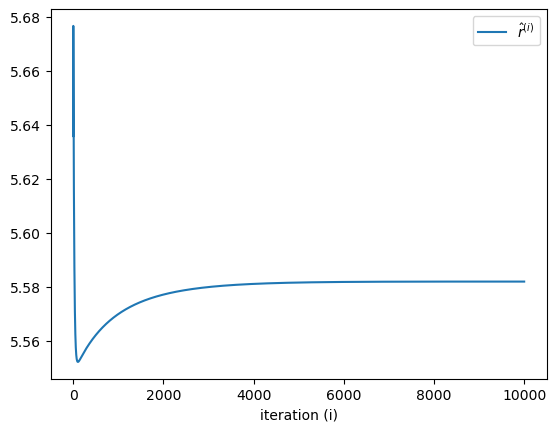

In [51]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

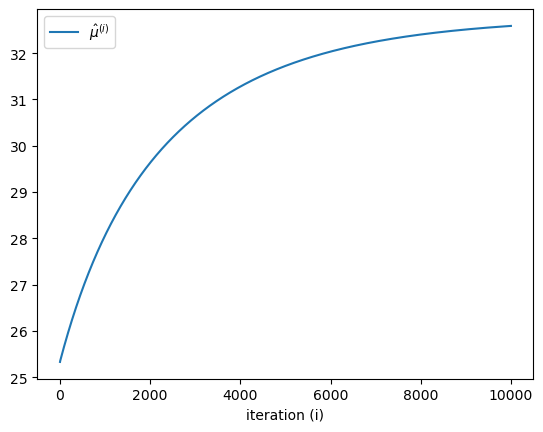

In [52]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

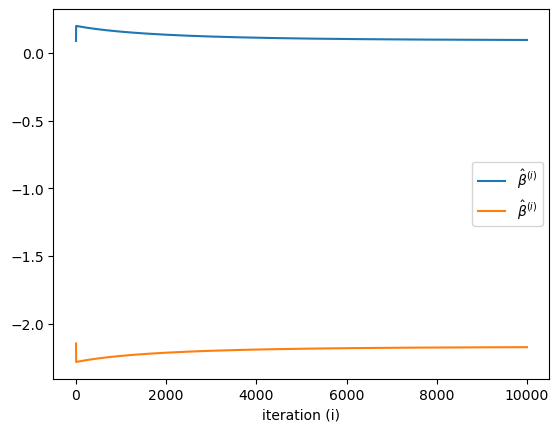

In [53]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [54]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [55]:
for t in np.arange(T+T0):
    o = np.exp(- bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [56]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [57]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [58]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [59]:
Pi_inv_ImG = Pi @ inv_ImG

In [60]:
EY = mmle_0 * Pi_inv_ImG[:,0]

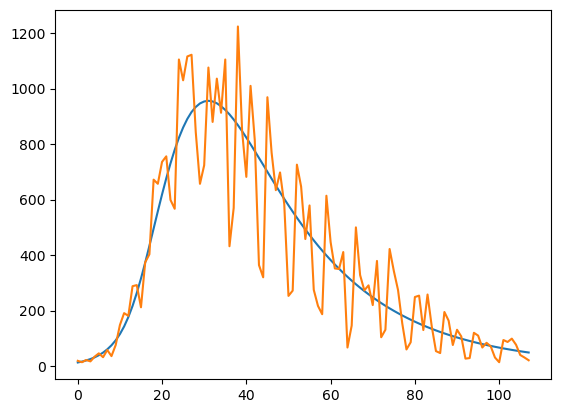

In [61]:
plt.plot(EY)
plt.plot(Y_data)

In [62]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [63]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [64]:
dldEY = Y_data/EY - (rmle+Y_data)/(rmle+EY)
d2ldEY2 = - Y_data/EY**2 + (rmle+Y_data)/(rmle+EY)**2
d2ldrdEY = - 1/(rmle+EY) + (rmle+Y_data)/(rmle+EY)**2

In [65]:
d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y_data, EY)])
d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
       + np.sum(dldEY * d2EY, 2)

d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
        + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

In [66]:
d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                    [d2ldrdm, d2ldm2]])
d2ldrmdb = np.stack([d2ldrdb, 
                     d2ldmdb])

In [67]:
Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                       [d2ldrmdb.T, d2ldb2]])

In [68]:
Ihat_dth

array([[ 1.26753288e-01, -4.67306838e-04, -3.06390539e-01,
        -2.48961165e-01],
       [-4.67306838e-04,  5.45296545e-01,  1.01790110e+02,
         5.58498956e+01],
       [-3.06390539e-01,  1.01790110e+02,  2.41762123e+04,
         1.51879312e+04],
       [-2.48961165e-01,  5.58498956e+01,  1.51879312e+04,
         1.01637120e+04]])

In [69]:
la.inv(Ihat_dth)[-2:,-2:]

array([[ 0.01412669, -0.01514074],
       [-0.01514074,  0.01645264]])

In [70]:
np.sqrt(la.inv(Ihat_dth)[2,2])

0.11885577061533914

In [71]:
np.sqrt(la.inv(Ihat_dth)[3,3])

0.128267835899222

# 5. Sandwich estimator

In [76]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [77]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [78]:
dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
dltdm = dldEY * Pi_inv_ImG[:,0]
dltdb = dldEY * d1EY

In [79]:
dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)

In [80]:
VEdl = dltdth @ w_HAC @ dltdth.T

In [81]:
VEdl

array([[2.23266463e+00, 2.92669319e-01, 6.61143524e+01, 4.01926946e+01],
       [2.92669319e-01, 3.70617102e-01, 8.80625132e+01, 5.57497028e+01],
       [6.61143524e+01, 8.80625132e+01, 2.41848806e+04, 1.63185564e+04],
       [4.01926946e+01, 5.57497028e+01, 1.63185564e+04, 1.13001337e+04]])

In [82]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [83]:
Ihat_sdw

array([[ 8.17201682e-03, -2.85790661e-02, -5.56302793e+00,
        -3.00145425e+00],
       [-2.85790661e-02,  1.14604755e+00,  1.69450074e+02,
         7.60027739e+01],
       [-5.56302793e+00,  1.69450074e+02,  3.21956637e+04,
         1.74449387e+04],
       [-3.00145425e+00,  7.60027739e+01,  1.74449387e+04,
         1.06057951e+04]])

In [84]:
Ihat_dth

array([[ 1.26753288e-01, -4.67306838e-04, -3.06390539e-01,
        -2.48961165e-01],
       [-4.67306838e-04,  5.45296545e-01,  1.01790110e+02,
         5.58498956e+01],
       [-3.06390539e-01,  1.01790110e+02,  2.41762123e+04,
         1.51879312e+04],
       [-2.48961165e-01,  5.58498956e+01,  1.51879312e+04,
         1.01637120e+04]])

In [85]:
la.inv(Ihat_sdw)[-2:,-2:]

array([[ 0.0046196 , -0.00513932],
       [-0.00513932,  0.00590263]])

In [86]:
np.sqrt(la.inv(Ihat_sdw)[2,2])

0.06796764595902521

In [87]:
np.sqrt(la.inv(Ihat_sdw)[3,3])

0.07682860390738729